# ***树模型（集成学习）及其性质***

树模型既是一个拥有极高精度（比普通的统计学习模型预测准确）的预测模型，也是拥有两个重要数据分析性质的模型：

树模型有两种决策数集成方法：
- Bagging
- Boosting

分类规律有三种探究方法：
- 最不可靠但是很直观的是：多变量分布可视化
- 最数学的是：使用逻辑回归、线性支持向量机等具有数学解释性、可以导出解析式的分类模型
- 最科学、最直观的是树模型

树模型有两个重要性质：
- 树状图导出：树状图可以直观地、定量地分析分类规律，仅在分类模型使用，回归模型意义不大
- 特征重要性：树模型可以导出特征重要性，用于特征选择，在回归模型和分类模型中都有应用

比赛的过程中：
- 只有一次机器学习预测：使用LightGBM
- 有多次机器学习预测：先使用传统模型或Voting
- 需要导出树状图：使用XGBoost

In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree

In [2]:
df_reg = pd.read_excel("data\\boston_house_prices.xlsx")
df_cls = pd.read_excel("data\\iris.xlsx")

X1 = df_reg.drop("MEDV", axis=1)    # 选择特征空间X
y1 = df_reg.MEDV    # 选择标签y
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)     # 划分数据集

X2 = df_cls.drop("class", axis=1)
y2 = df_cls['class']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

## **随机森林：基于Bagging方法的树模型**

In [3]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# 第一步：初始化模型（随机森林模型）
random_forest_cls = RandomForestClassifier()

# 第二部：用训练集拟合模型
random_forest_cls.fit(X2_train, y2_train)

# 第三步：用模型进行预测
y_pred = random_forest_cls.predict(X2_test)

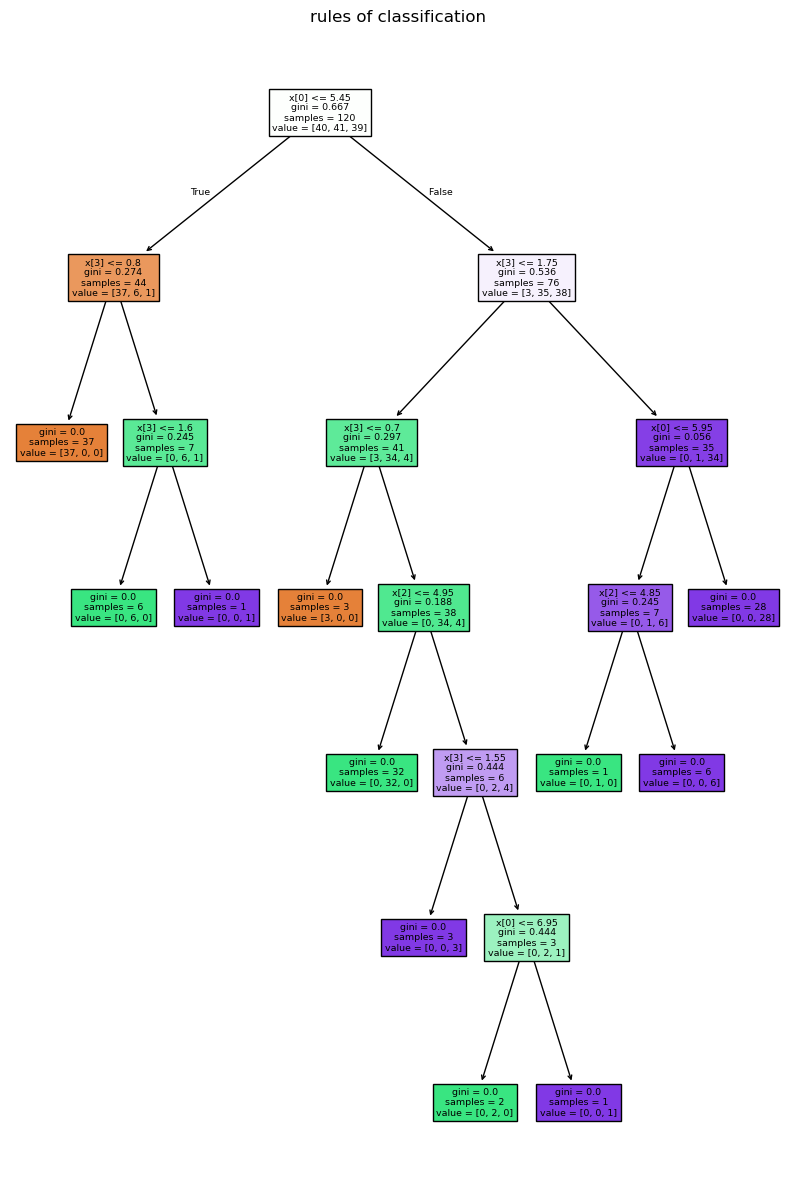

In [4]:
plt.figure(figsize=(10, 15))

estimator = random_forest_cls.estimators_[4]
estimator.fit(X2_train, y2_train)
plot_tree(estimator, filled=True)
plt.title("rules of classification")
plt.show()

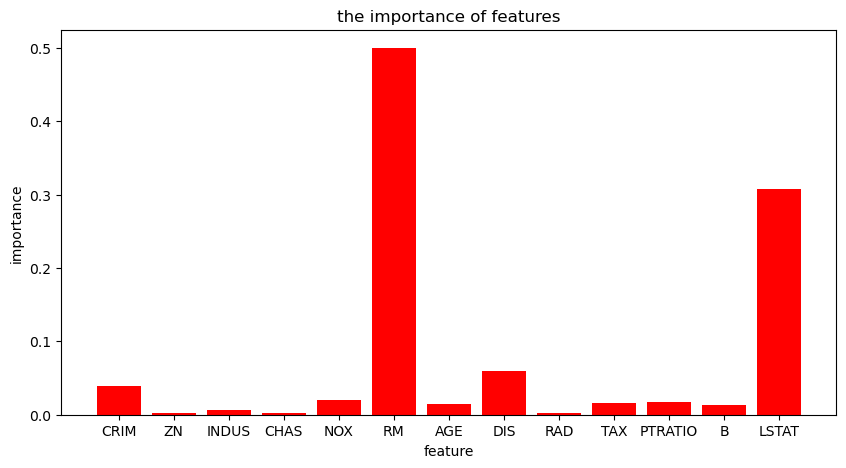

In [5]:
random_forest_reg = RandomForestRegressor().fit(X1_train, y1_train)

# 柱状图可视化特征重要性程度
plt.figure(figsize=(10, 5))
plt.title("the importance of features")
plt.xlabel("feature")
plt.ylabel("importance")
plt.bar(X1.columns, random_forest_reg.feature_importances_, color='r')
plt.show()

## **XGBoost**


In [6]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 尽量把学习率设置的高点，这样迭代的时间会短些
# 此处以回归器为例，分类器同理
xgb_reg = xgb.XGBRegressor(learning_rate=0.1)

param1 = {
        "max_depth":[4, 7, 10],
        'min_child_weight': [1, 3, 5],
        "n_estimators":[10, 50, 100],
        'gamma': [0.1, 0.3, 0.5],
        'reg_alpha': [0.05, 0.1, 1], 
        'reg_lambda': [0.05, 0.1, 1]
        }

grid_search1 = GridSearchCV(xgb_reg, n_jobs=-1, param_grid=param1, cv=5)
grid_search1.fit(X1_train, y1_train)


grid_search1.best_estimator_, grid_search1.best_score_

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 0.8591105428281706)

### 最优模型拟合与预测

In [7]:
xgb_reg_PLUS = grid_search1.best_estimator_
y1_pred = xgb_reg_PLUS.fit(X1_train, y1_train).predict(X1_test)

### 具有解释性的可视化

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

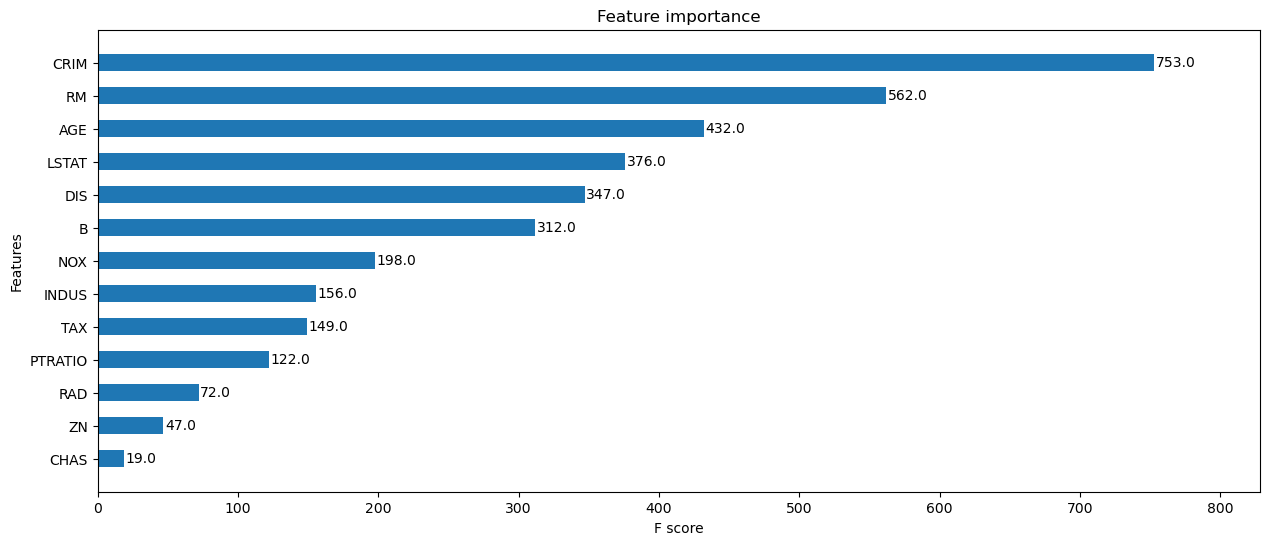

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

xgb.plot_importance(xgb_reg_PLUS, ax=ax, height=0.5, 
                title='Feature importance', xlabel='F score', ylabel='Features', 
                grid=False, show_values=True)

安装graphviz不简单，首先去这个软件的官网获取安装包并完成安装，注意安装路径选择：D:\Coding\python\Lib\site-packages

下一步就是pip install graphviz

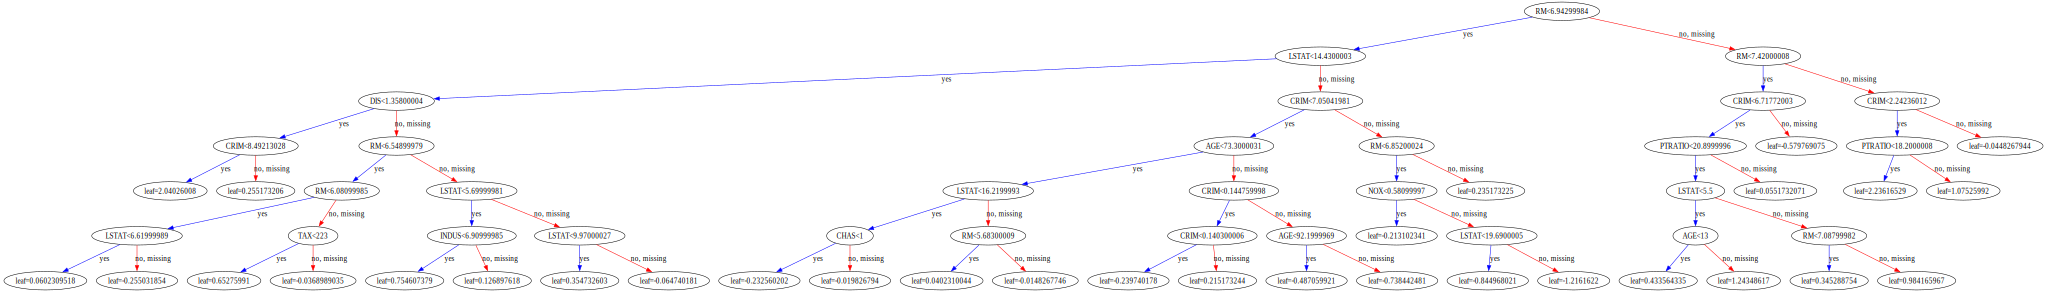

In [10]:
xgb.to_graphviz(xgb_reg_PLUS, fmap='', num_trees=0, rankdir=None, yes_color="red", no_color="blue")

## **LightGBM**

In [11]:
import lightgbm as lgb
"""
lgb_reg = lgb.LGBMRegressor(learning_rate=0.1)
param2 = {
        "max_depth":[4, 7, 10],
        "num_leaves":[300, 600, 900],
        "n_estimators":[10, 70, 130],
        'min_child_samples': [18, 20, 22],
        'min_child_weight':[0.001, 0.002]
        }
"""
# grid_search2 = GridSearchCV(lgb_reg, n_jobs=-1, param_grid=param2, cv=5)
# grid_search2.fit(X1_train, y1_train)
# grid_search2.best_estimator_, grid_search1.best_score_

'\nlgb_reg = lgb.LGBMRegressor(learning_rate=0.1)\nparam2 = {\n        "max_depth":[4, 7, 10],\n        "num_leaves":[300, 600, 900],\n        "n_estimators":[10, 70, 130],\n        \'min_child_samples\': [18, 20, 22],\n        \'min_child_weight\':[0.001, 0.002]\n        }\n'

### 最优模型拟合与预测

In [12]:
# lgb_reg_PLUS = grid_search2.best_estimator_
# y1_pred = lgb_reg_PLUS.fit(X1_train, y1_train).predict(X1_test)

In [13]:
lgb_reg_PLUS = lgb.LGBMRegressor(learning_rate=0.1)
lgb_reg_PLUS.fit(X1_train, y1_train)
y1_pred = lgb_reg_PLUS.predict(X1_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 13
[LightGBM] [Info] Start training from score 22.796535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

### 具有解释性的可视化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

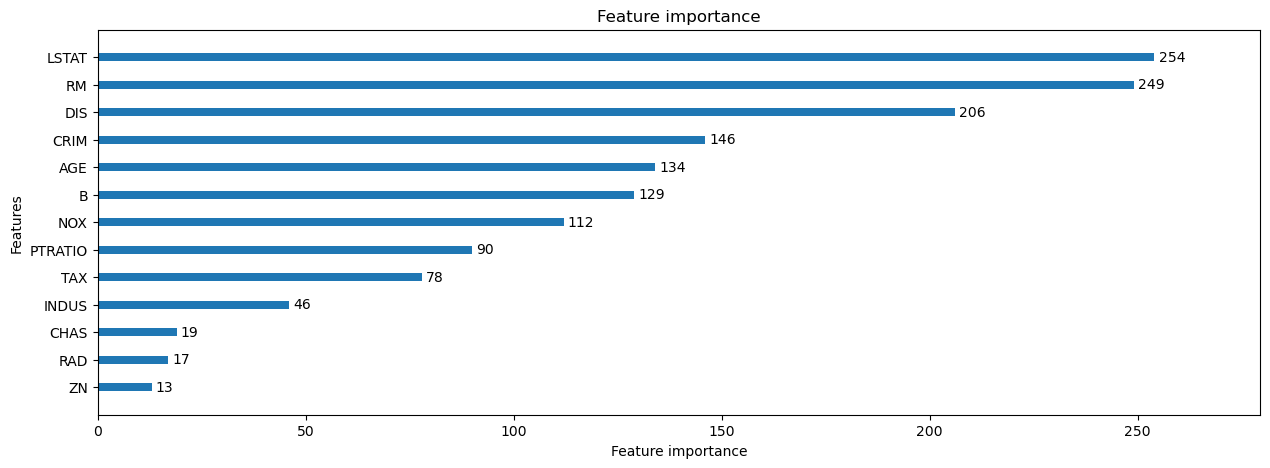

In [14]:
lgb.plot_importance(lgb_reg_PLUS, ax=None, height=0.3, 
                title='Feature importance', xlabel='Feature importance', ylabel='Features', 
                importance_type='auto', max_num_features=None, ignore_zero=True, 
                figsize=(15, 5), dpi=None, grid=False, precision=3)

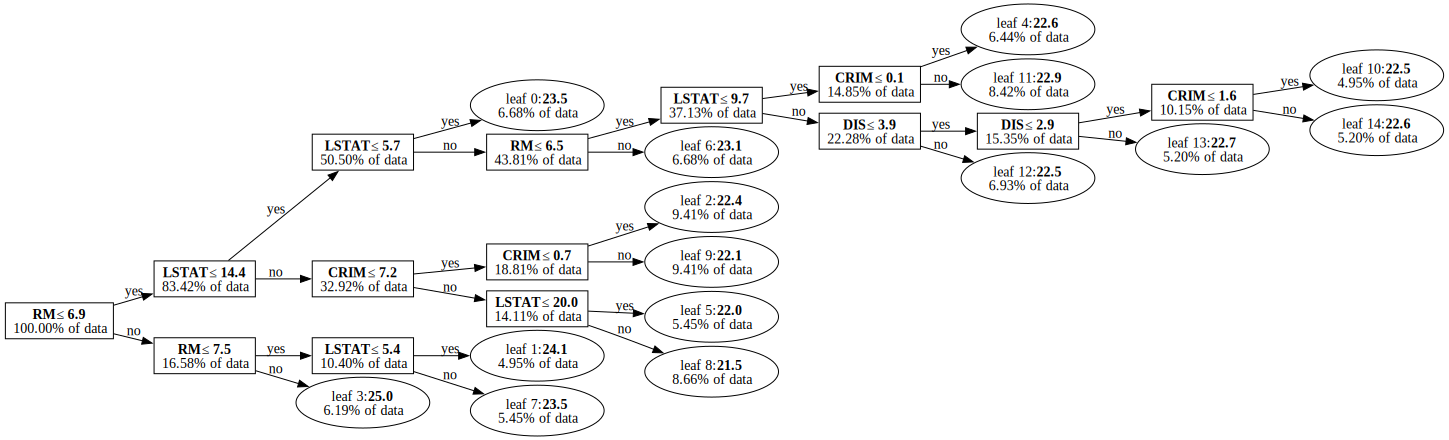

In [15]:
lgb.create_tree_digraph(lgb_reg_PLUS, tree_index=0, show_info='data_percentage', precision=1)